In [1]:
import seaborn as sns
import pandas as pd


pd.set_option("display.max_columns", None)

In [2]:
steps_df = pd.read_csv("data/1000_scenarios.csv")
steps_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 632891 entries, 0 to 632890
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            632891 non-null  int64  
 1   overtake_vehicle_num  632891 non-null  int64  
 2   velocity              632891 non-null  float64
 3   steering              632891 non-null  float64
 4   acceleration          632891 non-null  float64
 5   step_energy           632891 non-null  float64
 6   episode_energy        632891 non-null  float64
 7   policy                632891 non-null  object 
 8   crash_vehicle         632891 non-null  bool   
 9   crash_object          632891 non-null  bool   
 10  crash_building        632891 non-null  bool   
 11  crash_human           632891 non-null  bool   
 12  crash_sidewalk        632891 non-null  bool   
 13  out_of_road           632891 non-null  bool   
 14  arrive_dest           632891 non-null  bool   
 15  

In [3]:
steps_df["out_of_road"].value_counts()

out_of_road
False    632883
True          8
Name: count, dtype: int64

In [4]:
def drop_boring_columns(df):
    # if a column has one elements its boring lets drop it
    for series_name, series in df.items():
        if len(series.apply(str).unique()) == 1:
            df = df.drop(series_name, axis=1)
            print(f"Dropped: {series_name}")

    return df


steps_df = drop_boring_columns(steps_df)

Dropped: overtake_vehicle_num
Dropped: policy
Dropped: crash_object
Dropped: crash_building
Dropped: crash_human


In [5]:
grouped = steps_df.groupby(by=["decision_repeat", "env_seed"])
scenarios_df = grouped.last()
# scenarios_df

In [6]:
def validate_termination(s: pd.Series):
    return s["crash"] or s["arrive_dest"] or s["max_step"]


scenarios_df["validate_termination"] = scenarios_df.apply(validate_termination, axis=1)
scenarios_df["validate_termination"].value_counts()

validate_termination
True    4000
Name: count, dtype: int64

In [7]:
assert scenarios_df[
    ~scenarios_df["validate_termination"]
].empty, "Some scenarios termination was not valid!"

In [8]:
# was there any out of road episode?
any_out_of_road = grouped["out_of_road"].agg(any)
any_out_of_road.value_counts()

out_of_road
False    3992
True        8
Name: count, dtype: int64

In [9]:
any_crash = grouped["crash"].agg(any)
any_crash.value_counts()

crash
False    3169
True      831
Name: count, dtype: int64

In [10]:
episode_length = grouped["episode_length"].last()
episode_length

decision_repeat  env_seed
5                0           314.0
                 1           226.0
                 2           337.0
                 3           282.0
                 4            92.0
                             ...  
20               995          52.0
                 996          26.0
                 997          79.0
                 998          77.0
                 999          90.0
Name: episode_length, Length: 4000, dtype: float64

In [11]:
rq1 = episode_length.groupby("decision_repeat").sum()
rq1

decision_repeat
5     287276.0
10    149023.0
15    106348.0
20     86244.0
Name: episode_length, dtype: float64

In [12]:
scenarios_df = pd.concat([any_out_of_road, any_crash], axis=1)
scenarios_df.value_counts()

out_of_road  crash
False        False    3169
             True      823
True         True        8
Name: count, dtype: int64

In [33]:
oracle = scenarios_df.xs(5, level="decision_repeat")

In [43]:
def count_diffrent(scenario_df: pd.Series):

    x = scenario_df.reset_index(drop=True).compare(oracle.reset_index(drop=True))
    return len(x) / len(scenario_df)

In [44]:
rq2 = scenarios_df.groupby("decision_repeat").apply(count_diffrent)

<Axes: xlabel='decision_repeat'>

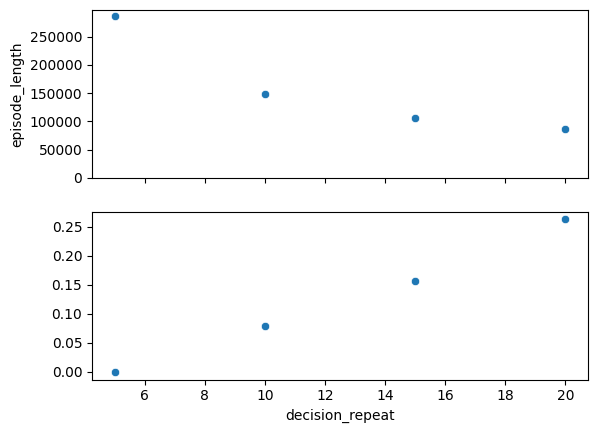

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, sharex=True)

sns.scatterplot(rq1, ax=ax1)
ax1.set_ylim(0)

sns.scatterplot(rq2, ax=ax2)